In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/nguyenvulebinh/extractive-qa-mrc
%cd /content/extractive-qa-mrc

Cloning into 'extractive-qa-mrc'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 59 (delta 20), reused 31 (delta 4), pack-reused 0
Receiving objects: 100% (59/59), 16.06 MiB | 10.11 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/extractive-qa-mrc


In [3]:
!pip install rank_bm25
!pip install rouge
!pip install underthesea
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 43.7 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split,DataLoader,Dataset

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders, processors
from transformers import BertModel, BertTokenizer, BertConfig, AutoTokenizer,BertForQuestionAnswering, AdamW, AutoModelForQuestionAnswering,AdamW,get_linear_schedule_with_warmup
from transformers import GPT2LMHeadModel, GPT2Tokenizer, pipeline, GPT2Config
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from infer import tokenize_function, data_collator, extract_answer
from model.mrc_model import MRCQuestionAnswering

import pandas as pd
import numpy as np
from collections import Counter
from rouge import Rouge
import matplotlib.pyplot as plt
import pickle
import time

from rank_bm25 import BM25Okapi
from underthesea import word_tokenize

import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/Q&Av7.csv',index_col = 0)
df.head()

,question,context,answer
N.o,,,
1,Khi nào là thời gian tuyển sinh đại học?,Thời gian tuyển sinh đại học thường diễn ra v...,tháng 6 đến tháng 8 hàng năm
2,Làm thế nào để đăng ký dự thi đại học?,Bạn có thể đăng ký dự thi đại học trực tuyến ...,NaN
3,Có bao nhiêu đợt tuyển sinh trong một năm?,Thường có hai đợt tuyển sinh chính trong một ...,hai
4,Cần những giấy tờ gì khi đăng ký tuyển sinh đạ...,"Bạn cần có các giấy tờ như hộ chiếu, bằng tốt...","hộ chiếu , bằng tốt nghiệp THPT , và một số gi..."
5,Làm thế nào để kiểm tra kết quả xét tuyển?,Kết quả xét tuyển thường được công bố trên tr...,NaN


In [ ]:

df = df.dropna(subset=['context', 'question', 'answer'])
df.shape

(2490, 3)

In [ ]:
contexts = df.context.tolist()
questions = df.question.tolist()
answers = df.answer.tolist()

#**1. Retriever**

##**1.1 classic IR**

In [5]:
class RetrievalQA:
    def __init__(self, questions, contexts, model_type='tfidf'):
        self.questions = questions
        self.contexts = contexts
        self.model_type = model_type

        if self.model_type == 'tfidf':
            self.vectorizer = TfidfVectorizer()
            self.question_embeddings = self.vectorizer.fit_transform(self.questions)

        elif self.model_type == 'bm25':
            self.tokenized_docs = [word_tokenize(doc) for doc in contexts]
            self.bm25 = BM25Okapi(self.tokenized_docs)

    def retrieve_context(self, query):
        query_embedding = None
        if self.model_type == 'tfidf':
            query_embedding = self.vectorizer.transform([query])
            similarities = cosine_similarity(query_embedding, self.question_embeddings).flatten()
            most_similar_index = np.argmax(similarities)
            return self.contexts[most_similar_index]

        elif self.model_type == 'bm25':
            tokenized_query = word_tokenize(query)
            scores = self.bm25.get_scores(tokenized_query)
            most_similar_index = np.argmax(scores)
            return self.contexts[most_similar_index]

    def score_question(self, input_question):
        if self.model_type == 'tfidf':
            input_question_embedding = self.vectorizer.transform([input_question])
            similarities = cosine_similarity(input_question_embedding, self.question_embeddings).flatten()
            max_similarity = np.max(similarities)
            return max_similarity
        elif self.model_type == 'bm25':
            tokenized_input_question = word_tokenize(input_question)
            scores = self.bm25.get_scores(tokenized_input_question)
            max_similarity = np.max(scores)
            return max_similarity

    def _check_similarity(self, new_question_embedding):
        similarities = cosine_similarity(new_question_embedding, self.question_embeddings).flatten()
        max_similarity = np.max(similarities)
        return max_similarity, np.argmax(similarities)

    def update_model(self, new_questions, new_contexts, similarity_threshold=0.8):
        if self.model_type == 'tfidf':
            for new_question, new_context in zip(new_questions, new_contexts):
                new_question_embedding = self.vectorizer.transform([new_question])

                max_similarity, most_similar_index = self._check_similarity(new_question_embedding)

                if max_similarity >= similarity_threshold:
                    self.questions[most_similar_index] = new_question
                    self.contexts[most_similar_index] = new_context
                else:
                    self.questions.append(new_question)
                    self.contexts.append(new_context)

            self.question_embeddings = self.vectorizer.fit_transform(self.questions)
        elif self.model_type == 'bm25':
            for new_question, new_context in zip(new_questions, new_contexts):
                self.questions.append(new_question)
                self.contexts.append(new_context)

            self.tokenized_docs = [word_tokenize(doc) for doc in self.contexts]
            self.bm25 = BM25Okapi(self.tokenized_docs)

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)

    @classmethod
    def load_model(cls, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        return model


In [ ]:
retrieval_model = RetrievalQA(questions, contexts, model_type='tfidf')
retrieval_model.save_model("/content/drive/MyDrive/datasets/model/retriever/retriever_tfidf.pkl")

In [ ]:
retrieval_model = RetrievalQA(questions, contexts, model_type='bm25')
retrieval_model.save_model("/content/drive/MyDrive/datasets/model/retriever/retriever_bm25.pkl")

In [ ]:
loaded_model  = RetrievalQA.load_model("/content/drive/MyDrive/datasets/model/retriever/retriever_bm25.pkl")

In [ ]:
query = "điểm chuẩn là cái gì"
retrieved_context = retrieval_model.retrieve_context(query)
print(retrieved_context)

3
 Điểm chuẩn là điểm tối thiểu cần đạt để được nhận vào một ngành học cụ thể


#**2. Reader**

##**2.1 Bidirectional LSTM**

###**2.1.1 Train**

In [6]:
class BiLSTMReader(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, max_seq_length):
        super(BiLSTMReader, self).__init__()

        # Word Embeddings
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)

        # Bidirectional LSTM
        self.bilstm_layer = nn.LSTM(embedding_dim, hidden_size, bidirectional=True, batch_first=True)

        # Question Encoder
        self.question_encoder = nn.Linear(embedding_dim, embedding_dim)

        # Answer Span Prediction
        self.start_pred_layer = nn.Linear(hidden_size * 2, 1)
        self.end_pred_layer = nn.Linear(hidden_size * 2, 1)

    def forward(self, context, question):
        # Word Embeddings for Context
        context_emb = self.embedding_layer(context)

        # Bidirectional LSTM on Context
        context_lstm, _ = self.bilstm_layer(context_emb)

        # Weighted Sum for Question
        question_emb = self.embedding_layer(question)
        question_weight = torch.sum(question_emb, dim=1)
        question_weight = question_weight.unsqueeze(1)
        question_encoded = torch.sum(question_emb * question_weight, dim=1)
        question_encoded = self.question_encoder(question_encoded)

        # Start and End Prediction
        start_pred = self.start_pred_layer(context_lstm)
        end_pred = self.end_pred_layer(context_lstm)

        return start_pred, end_pred

In [ ]:
class QADataset(Dataset):
    def __init__(self, questions, contexts, answers, tokenizer, max_length):
        self.questions = questions
        self.contexts = contexts
        self.answers = answers
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.contexts[idx]
        answer = self.answers[idx]

        # Tokenize question and context
        inputs = self.tokenizer(question, context, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)

        # Extract start and end positions of the answer span
        start_token_id = self.tokenizer(answer, return_tensors='pt')['input_ids'][0][1].item()
        end_token_id = self.tokenizer(answer, return_tensors='pt')['input_ids'][0][-2].item()

        input_ids = inputs['input_ids'].squeeze().tolist()

        # Check if start_token_id and end_token_id are in the tokenized input
        if start_token_id in input_ids and end_token_id in input_ids:
            start_position = torch.tensor([input_ids.index(start_token_id)])
            end_position = torch.tensor([input_ids.index(end_token_id)])
        else:
            # Handle the case where start or end tokens are not present in the input
            start_position = torch.tensor([0])
            end_position = torch.tensor([len(input_ids) - 1])

        return inputs['input_ids'].squeeze(), inputs['attention_mask'].squeeze(), start_position, end_position


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')

# Combine contexts, questions, and answers
all_text = [f"{context} {question} {answer}" for context, question, answer in zip(contexts, questions, answers)]

# Tokenize using a transformer-based tokenizer
tokenized_texts = tokenizer(all_text, padding=True, truncation=True, return_tensors='pt', return_token_type_ids=False)

# Get the input IDs
all_input_ids = tokenized_texts['input_ids']

# Flatten the list of input IDs
flat_input_ids = [token_id for sublist in all_input_ids.tolist() for token_id in sublist]

# Calculate vocabulary size
vocab_size = len(set(flat_input_ids))
print(f"Vocabulary Size: {vocab_size}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Vocabulary Size: 2012


In [ ]:
# Define the split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
max_length = 64
# Calculate the sizes of each split
total_size = len(questions)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    QADataset(questions, contexts, answers, tokenizer, max_length),
    [train_size, val_size, test_size]
)

# Define batch size
batch_size = 64

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Instantiate the model, loss, and optimizer
vocab_size = len(tokenizer.get_vocab())
embedding_dim = 256
hidden_size = 128
max_seq_length = max_length

model = BiLSTMReader(vocab_size, embedding_dim, hidden_size, max_seq_length)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optionally, move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BiLSTMReader(
  (embedding_layer): Embedding(64001, 256)
  (bilstm_layer): LSTM(256, 128, batch_first=True, bidirectional=True)
  (question_encoder): Linear(in_features=256, out_features=256, bias=True)
  (start_pred_layer): Linear(in_features=256, out_features=1, bias=True)
  (end_pred_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
num_epochs = 25
for epoch in range(num_epochs):
    for batch in train_dataloader:
        input_ids, attention_mask, start_positions, end_positions = [tensor.to(device) for tensor in batch]

        # Forward pass
        start_pred, end_pred = model(input_ids, attention_mask)
        # Compute the loss
        start_loss = criterion(start_pred, start_positions)
        end_loss = criterion(end_pred, end_positions)
        total_loss = start_loss + end_loss

        # Backward pass
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # Validation loop (optional)
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_input_ids, val_attention_mask, val_start_positions, val_end_positions = [tensor.to(device) for tensor in val_batch]
            val_start_pred, val_end_pred = model(val_input_ids, val_attention_mask)
            # Compute and print validation metrics if needed

    # Print or log training and validation loss for monitoring
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss.item()}')

# Save the trained model if needed
torch.save(model.state_dict(), '/content/drive/MyDrive/datasets/model/reader/bilstm_reader_model.pth')

###**2.1.2 Test**

In [ ]:
query = "điểm chuẩn là cái gì"
retrieval_model = RetrievalQA.load_model('/content/drive/MyDrive/datasets/model/retriever/retriever_tfidf.pkl')
retrieved_context = retrieval_model.retrieve_context(query)
print("context:",end=" ")
print(retrieved_context)
# Tokenize the input using your tokenizer
inputs = tokenizer(query, retrieved_context, return_tensors='pt', max_length=max_seq_length, padding='max_length', truncation=True)

# Manually specify the device for the input tensors
inputs = {key: value.to("cuda:0") for key, value in inputs.items()}

# Move the model to the same device as the inputs
model = model.to("cuda:0")

# Forward pass through the model
with torch.no_grad():
    start_pred, end_pred = model(inputs['input_ids'], inputs['attention_mask'])

# Post-process the predictions if needed
# For example, you might want to find the indices of the maximum values for start and end predictions
start_index = torch.argmax(start_pred)
end_index = torch.argmax(end_pred)

# Extract the answer span from the input_ids
answer_span = inputs['input_ids'][0][start_index:end_index + 1]

# Convert the answer span back to tokens using the tokenizer
predicted_answer = tokenizer.decode(answer_span)

print("Predicted Answer:", predicted_answer)

context:  Điểm chuẩn là điểm tối thiểu cần đạt để được nhận vào một ngành học cụ thể
Predicted Answer: điểm tối thiểu cần đạt để được nhận vào một ngành học cụ thể


#**2. PhoBERT**

##**2.1 Fine-tuning**

In [ ]:
class QADataset(Dataset):
    def __init__(self, questions, contexts, answers, tokenizer, max_seq_length=512):
        self.questions = questions
        self.contexts = contexts
        self.answers = answers
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.contexts[idx]
        answer_text = self.answers[idx]  # Assuming answer is a string

        # Tokenize and encode the input data
        encoded = self.tokenizer(question, context, return_tensors="pt", padding=True, truncation=True, max_length=self.max_seq_length)

        # Find the start and end positions of the answer span in tokens
        start_pos = context.find(answer_text)
        end_pos = start_pos + len(answer_text)

        return {
            'input_ids': encoded['input_ids'][0],
            'attention_mask': encoded['attention_mask'][0],
            'start_positions': start_pos,
            'end_positions': end_pos
        }

def collate_fn(batch):
    """
    Collate function to handle variable-length sequences.
    """
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    start_positions = torch.tensor([item['start_positions'] for item in batch], dtype=torch.long)
    end_positions = torch.tensor([item['end_positions'] for item in batch], dtype=torch.long)

    # Pad sequences dynamically
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'start_positions': start_positions,
        'end_positions': end_positions
    }

In [ ]:
# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModelForQuestionAnswering.from_pretrained("vinai/phobert-base")

# Prepare the dataset
dataset = QADataset(questions, contexts, answers, tokenizer)

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(num_epochs):
    start_time = time.time()

    total_loss = 0.0
    for batch_idx, batch in enumerate(train_dataloader):
        inputs = {key: value.to(device) for key, value in batch.items()}

        outputs = model(**inputs, return_dict=True)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    average_loss = total_loss / len(train_dataloader)
    end_time = time.time()  # Record the end time of the epoch
    epoch_time = end_time - start_time

    print(f"Epoch {epoch + 1}, Average Loss: {average_loss}, Time: {epoch_time} seconds")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at vinai/phob

Epoch 1, Average Loss: 3.5814926188633622, Time: 39.21781802177429 seconds
Epoch 2, Average Loss: 2.859536289211258, Time: 38.798638105392456 seconds
Epoch 3, Average Loss: 2.5125857002763863, Time: 36.19399094581604 seconds
Epoch 4, Average Loss: 2.1946568280817513, Time: 36.452068567276 seconds
Epoch 5, Average Loss: 1.9560487923851932, Time: 36.27204608917236 seconds


##**2.2 Test**

In [ ]:
model.save_pretrained("/content/drive/MyDrive/datasets/model/generator/phobert-finetune")
tokenizer.save_pretrained("/content/drive/MyDrive/datasets/model/generator/phobert-finetune")

('/content/drive/MyDrive/datasets/model/generator/phobert-finetune/tokenizer_config.json',
 '/content/drive/MyDrive/datasets/model/generator/phobert-finetune/special_tokens_map.json',
 '/content/drive/MyDrive/datasets/model/generator/phobert-finetune/vocab.txt',
 '/content/drive/MyDrive/datasets/model/generator/phobert-finetune/bpe.codes',
 '/content/drive/MyDrive/datasets/model/generator/phobert-finetune/added_tokens.json')

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/datasets/model/generator/phobert-finetune")  # set use_fast=False to avoid potential issues
model = AutoModelForQuestionAnswering.from_pretrained("/content/drive/MyDrive/datasets/model/generator/phobert-finetune")
retriever_model = RetrievalQA(questions, contexts, model_type='tfidf')

question = "điểm chuẩn là gì"
context = retriever_model.retrieve_context(question)
encoded = tokenizer(question, context, return_tensors="pt", padding=True, truncation=True)
model.eval()
with torch.no_grad():
    outputs = model(**encoded)

start_logits = outputs.start_logits
end_logits = outputs.end_logits

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_tokens = encoded["input_ids"][0][start_idx:end_idx]
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))

# Step 5: Print the predicted answer
print("Question:", question)
print("Context:", context)
print("Predicted Answer:", answer)

Question: điểm chuẩn là gì
Context:  Điểm chuẩn là điểm tối thiểu cần đạt để được nhận vào một ngành học cụ thể
Predicted Answer: thiểu cần


#**3. GPT-2**

In [ ]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00


In [ ]:
!pip install transformers[torch] -U


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/Q&Av7.csv',index_col = 0)
df = df.dropna(subset=['context', 'question', 'answer'])
df = df.drop(columns='context')

dataset_path = "/content/drive/MyDrive/datasets/combined_dataset.txt"
df.to_csv(dataset_path, sep='\t', index=False, header=False)  # Adjust sep if needed

In [ ]:
# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('NlpHUST/gpt2-vietnamese')
model = GPT2LMHeadModel.from_pretrained('NlpHUST/gpt2-vietnamese')

dataset_path = "/content/drive/MyDrive/datasets/combined_dataset.txt"
dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=dataset_path,
    block_size=128  # Adjust block_size based on your dataset
)

# Prepare data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# Fine-tuning arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/datasets/model/gpt-2",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("/content/drive/MyDrive/datasets/model/gpt-2")
tokenizer.save_pretrained("/content/drive/MyDrive/datasets/model/gpt-2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/854k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/512k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Step,Training Loss
500,1.216300


('/content/drive/MyDrive/datasets/model/gpt-2/tokenizer_config.json',
 '/content/drive/MyDrive/datasets/model/gpt-2/special_tokens_map.json',
 '/content/drive/MyDrive/datasets/model/gpt-2/vocab.json',
 '/content/drive/MyDrive/datasets/model/gpt-2/merges.txt',
 '/content/drive/MyDrive/datasets/model/gpt-2/added_tokens.json')

In [ ]:

# Load fine-tuned GPT-2 model and tokenizer
fine_tuned_model = GPT2LMHeadModel.from_pretrained("/content/drive/MyDrive/datasets/model/gpt-2")
tokenizer = GPT2Tokenizer.from_pretrained("/content/drive/MyDrive/datasets/model/gpt-2")

In [ ]:
# Input question
question = "Điểm chuẩn là gì ?"
# Tokenize and generate answer
input_ids = tokenizer.encode(question, return_tensors="pt")
max_length = 50

output = fine_tuned_model.generate(input_ids,pad_token_id=tokenizer.eos_token_id,
                                   do_sample=True,
                                   max_length=max_length,
                                   min_length=max_length,
                                   top_k=40,
                                   num_beams=5,
                                   early_stopping=True,
                                   no_repeat_ngram_size=2,
                                   num_return_sequences=3)
# Decode and print the answer
answer = tokenizer.decode(output[0], skip_special_tokens=True)
print("Câu trả lời:", answer)

Câu trả lời: Điểm chuẩn là gì?	 Điểm chuẩn thường được xác định dựa trên điểm trung bình của các môn học trong chương trình đào tạo, bao gồm điểm số bài thi, kết quả học tập và điểm thi tuyển sinh.	điểm chuẩn
Làm thế


#**4. Evaluation**

In [7]:
tf_idf  = RetrievalQA.load_model('/content/drive/MyDrive/datasets/model/retriever/retriever_tfidf.pkl')

bm_25 = RetrievalQA.load_model('/content/drive/MyDrive/datasets/model/retriever/retriever_bm25.pkl')

bilstm = BiLSTMReader(64001, 256, 128, 64)
if not torch.cuda.is_available():
    bilstm.load_state_dict(torch.load('/content/drive/MyDrive/datasets/model/reader/bilstm_reader_model.pth', map_location=torch.device('cpu')))
else:
    bilstm.load_state_dict(torch.load('/content/drive/MyDrive/datasets/model/reader/bilstm_reader_model.pth'))
tokenizer_bilstm = AutoTokenizer.from_pretrained('vinai/phobert-base')
bilstm.eval()

tokenizer_phobert = AutoTokenizer.from_pretrained("/content/drive/MyDrive/datasets/model/generator/phobert-finetune")
phobert = AutoModelForQuestionAnswering.from_pretrained("/content/drive/MyDrive/datasets/model/generator/phobert-finetune")

gpt2 = GPT2LMHeadModel.from_pretrained("/content/drive/MyDrive/datasets/model/gpt-2")
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("/content/drive/MyDrive/datasets/model/gpt-2")


tokenizer_vimrc = AutoTokenizer.from_pretrained("nguyenvulebinh/vi-mrc-large")
vimrc = MRCQuestionAnswering.from_pretrained('nguyenvulebinh/vi-mrc-large')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [48]:
df = pd.read_csv('/content/drive/MyDrive/datasets/Q&Av7.csv',index_col = 0)
df = df.dropna(subset=['context', 'question', 'answer'])
df_test = df.sample(n=50, random_state=55)
df_test.head()

,question,context,answer
N.o,,,
375,Cách xác định nguyện vọng ngành nghề khi đăng ...,"Nên tự đánh giá sở thích, kỹ năng, và mục tiêu...","tự đánh giá sở thích , kỹ năng , và mục tiêu n..."
192,Cần những giấy tờ gì khi đăng ký tuyển sinh?,"Thông thường, bạn cần hộ chiếu, bằng tốt nghiệ...","hộ chiếu , bằng tốt nghiệp , và các giấy tờ li..."
2749,Ngành Kỹ thuật Môi trường có chương trình học ...,"Vâng, chúng tôi có chương trình học với sự tập...",Vâng
2760,Ngành Kỹ thuật Hóa học có chương trình học về ...,Ngành Kỹ thuật Hóa học thường có chương trình ...,có
1505,Học viên có cơ hội tham gia các dự án nghiên ...,"Tất nhiên, học viên có cơ hội tham gia vào cá...",có cơ hội


In [49]:
y_true = df_test.answer.tolist()
x_question = df_test.question.tolist()
y_true[:2]

['tự đánh giá sở thích , kỹ năng , và mục tiêu nghề nghiệp',
 'hộ chiếu , bằng tốt nghiệp , và các giấy tờ liên quan khác']

In [50]:
def processing_predicted_answer(answer):
    if("</s>" in answer or "<s>" in answer):
        answer = answer.replace("</s>","").replace("<s>","").replace("<pad>","").strip()
    return answer

def question_answering_bilstm(query, context):
        inputs = tokenizer_bilstm(query, context, return_tensors='pt', max_length=64, padding='max_length', truncation=True)

        with torch.no_grad():
            start_pred, end_pred = bilstm(inputs['input_ids'], inputs['attention_mask'])

        start_index = torch.argmax(start_pred)
        end_index = torch.argmax(end_pred)
        answer_span = inputs['input_ids'][0][start_index:end_index + 1]
        predicted_answer = tokenizer_bilstm.decode(answer_span)
        return processing_predicted_answer(predicted_answer)

def question_answering_phobert( question, context):
        encoded = tokenizer_phobert(question, context, return_tensors="pt", padding=True, truncation=True)
        phobert.eval()
        with torch.no_grad():
            outputs = phobert(**encoded)

        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        start_idx = torch.argmax(start_logits)
        end_idx = torch.argmax(end_logits) + 1

        answer_tokens = encoded["input_ids"][0][start_idx:end_idx]
        answer = tokenizer_phobert.convert_tokens_to_string(tokenizer_phobert.convert_ids_to_tokens(answer_tokens))
        return processing_predicted_answer(answer)

def generator_answering_gpt2(question):
  input_ids = tokenizer_gpt2.encode(question, return_tensors="pt")
  max_length = 50
  output = gpt2.generate(input_ids,pad_token_id=tokenizer_gpt2.eos_token_id,
                              do_sample=True,
                              max_length=max_length,
                              min_length=max_length,
                              top_k=40,
                              num_beams=5,
                              early_stopping=True,
                              no_repeat_ngram_size=2,
                              num_return_sequences=3)
  answer = tokenizer_gpt2.decode(output[0], skip_special_tokens=True)
  return answer

def question_answering_vimrc(question, context):
  QA_input = {
  'question': question,
  'context': context
  }

  inputs = [tokenize_function(QA_input, tokenizer_vimrc)]
  inputs_ids = data_collator(inputs, tokenizer_vimrc)
  outputs = vimrc(**inputs_ids)
  answer = extract_answer(inputs, outputs, tokenizer_vimrc)
  return answer[0]['answer']

In [ ]:
results = []
for i in range(len(y_true)):
  pred_blistm = question_answering_bilstm(x_question[i],bm_25.retrieve_context(x_question[i]))
  pred_phobert = question_answering_phobert(x_question[i],bm_25.retrieve_context(x_question[i]))
  pred_vimrc = question_answering_vimrc(x_question[i],bm_25.retrieve_context(x_question[i]))
  pred_gpt2 = generator_answering_gpt2(x_question[2])
  results.append({'true_answer':y_true[i],'pred_blistm':pred_blistm,
                        'pred_phobert':pred_phobert,'pred_vimrc':pred_vimrc,
                        'pred_gpt2':pred_gpt2})


In [54]:
results[0]

{'true_answer': 'tự đánh giá sở thích , kỹ năng , và mục tiêu nghề nghiệp',
 'pred_blistm': 'Cách xác định nguyện vọng ngành nghề khi đăng ký tuyển sinh là gì?   Thường không, nên xác định nguyện vọng trước khi bắt đầu kỳ thi',
 'pred_phobert': 'sinh là gì?   Thường không@@',
 'pred_vimrc': '',
 'pred_gpt2': 'Ngành Kỹ thuật Môi trường có chương trình học với sự tập trung vào phát triển công nghệ xanh không?\tChắc chắn, chúng tôi cung cấp cơ hội học tập trực tuyến, giúp sinh viên áp dụng kiến thức vào môi trường thực tế.\t'}

In [55]:

# Define a function to calculate BLEU score
def calculate_bleu_score(reference, hypothesis):
    reference = [reference.split()]
    hypothesis = hypothesis.split()

    return sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method4)

# Define a function to calculate ROUGE-1 score
def calculate_rouge_score(reference, hypothesis):
    rouge = Rouge()
    if(hypothesis == ''):
      hypothesis = '_'
    scores = rouge.get_scores(hypothesis, reference)

    return scores[0]['rouge-1']['f']

# Initialize lists to store individual scores
bleu_scores_bilstm = []
rouge_scores_bilstm = []

bleu_scores_phobert = []
rouge_scores_phobert = []

bleu_scores_vimrc = []
rouge_scores_vimrc = []

bleu_scores_gpt2 = []
rouge_scores_gpt2 = []

# Loop through your dataset and calculate scores for each example
for example in results:
    true_answer = example['true_answer']
    pred_bilstm = example['pred_blistm']
    pred_phobert = example['pred_phobert']
    pred_vimrc = example['pred_vimrc']
    pred_gpt2 = example['pred_gpt2']

    # Calculate BLEU and ROUGE scores for each model prediction
    bleu_scores_bilstm.append(calculate_bleu_score(true_answer, pred_bilstm))
    rouge_scores_bilstm.append(calculate_rouge_score(true_answer, pred_bilstm))

    bleu_scores_phobert.append(calculate_bleu_score(true_answer, pred_phobert))
    rouge_scores_phobert.append(calculate_rouge_score(true_answer, pred_phobert))

    bleu_scores_vimrc.append(calculate_bleu_score(true_answer, pred_vimrc))
    rouge_scores_vimrc.append(calculate_rouge_score(true_answer, pred_vimrc))

    bleu_scores_gpt2.append(calculate_bleu_score(true_answer, pred_gpt2))
    rouge_scores_gpt2.append(calculate_rouge_score(true_answer, pred_gpt2))

# Calculate average scores
average_bleu_bilstm = sum(bleu_scores_bilstm) / len(bleu_scores_bilstm)
average_rouge_bilstm = sum(rouge_scores_bilstm) / len(rouge_scores_bilstm)

average_bleu_phobert = sum(bleu_scores_phobert) / len(bleu_scores_phobert)
average_rouge_phobert = sum(rouge_scores_phobert) / len(rouge_scores_phobert)

average_bleu_vimrc = sum(bleu_scores_vimrc) / len(bleu_scores_vimrc)
average_rouge_vimrc = sum(rouge_scores_vimrc) / len(rouge_scores_vimrc)

average_bleu_gpt2 = sum(bleu_scores_gpt2) / len(bleu_scores_gpt2)
average_rouge_gpt2 = sum(rouge_scores_gpt2) / len(rouge_scores_gpt2)

# Print or use the average scores as needed
print(f"Average BLEU (BiLSTM): {average_bleu_bilstm}, Average ROUGE-1 (BiLSTM): {average_rouge_bilstm}")
print(f"Average BLEU (PhoBERT): {average_bleu_phobert}, Average ROUGE-1 (PhoBERT): {average_rouge_phobert}")
print(f"Average BLEU (ViMRC): {average_bleu_vimrc}, Average ROUGE-1 (ViMRC): {average_rouge_vimrc}")
print(f"Average BLEU (GPT-2): {average_bleu_gpt2}, Average ROUGE-1 (GPT-2): {average_rouge_gpt2}")


Average BLEU (BiLSTM): 0.3785846039615789, Average ROUGE-1 (BiLSTM): 0.45837324959485537
Average BLEU (PhoBERT): 0.033334434620718036, Average ROUGE-1 (PhoBERT): 0.13172766727201038
Average BLEU (ViMRC): 0.6517632678668044, Average ROUGE-1 (ViMRC): 0.6953392621967524
Average BLEU (GPT-2): 0.007917850372214801, Average ROUGE-1 (GPT-2): 0.060759232016368084


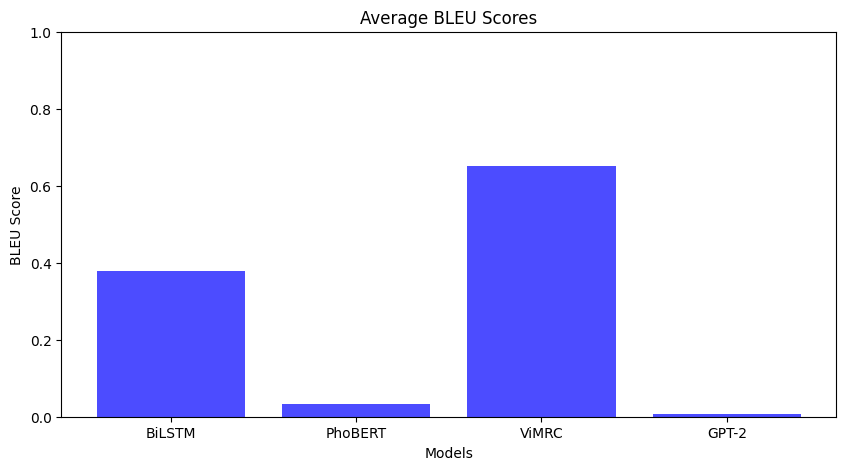

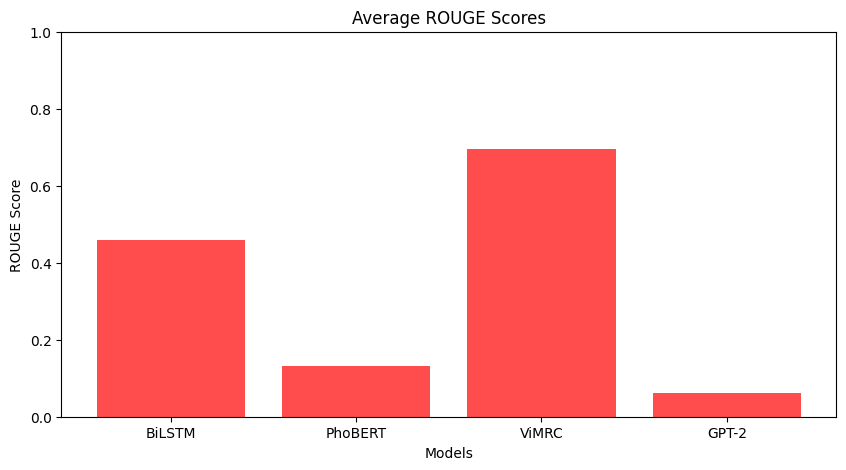

In [59]:
# Plotting
models = ['BiLSTM', 'PhoBERT', 'ViMRC', 'GPT-2']
average_bleu_scores = [average_bleu_bilstm, average_bleu_phobert, average_bleu_vimrc, average_bleu_gpt2]
average_rouge_scores = [average_rouge_bilstm, average_rouge_phobert, average_rouge_vimrc, average_rouge_gpt2]

# Plotting BLEU scores
plt.figure(figsize=(10, 5))
plt.bar(models, average_bleu_scores, color='blue', alpha=0.7)
plt.title('Average BLEU Scores')
plt.xlabel('Models')
plt.ylabel('BLEU Score')
plt.ylim(0, 1)  # Adjust the y-axis range if needed
plt.show()

# Plotting ROUGE-1 scores
plt.figure(figsize=(10, 5))
plt.bar(models, average_rouge_scores, color='red', alpha=0.7)
plt.title('Average ROUGE Scores')
plt.xlabel('Models')
plt.ylabel('ROUGE Score')
plt.ylim(0, 1)  # Adjust the y-axis range if needed
plt.show()
